In [45]:
using LinearAlgebra, Statistics, QuantEcon, Interpolations, Optim
using Distributions, Expectations, NLsolve, Roots, Random, Plots, Parameters
using LinearAlgebra, Statistics
using Distributions, Expectations, Parameters, NLsolve, Plots

In [65]:
b = 0.55
z = 0.85
θ = 100
λ = 0.23
δ = 0.026
β = 0.98

0.98

In [129]:
grid_w = range(0.8, 1.1, length = 200)
w = range(0.8, 1.1, length = 200)
dist = Frechet(θ,z)
F(w) = pdf(dist, w)
E = expectation(Frechet(θ,z),QuantileRange, n=200)


wag = LinearInterpolation(grid_w,grid_w,extrapolation_bc = Line())

E(x->wag(x))

Vu = 1
Ve = zeros(200,1)



Nite = 0;



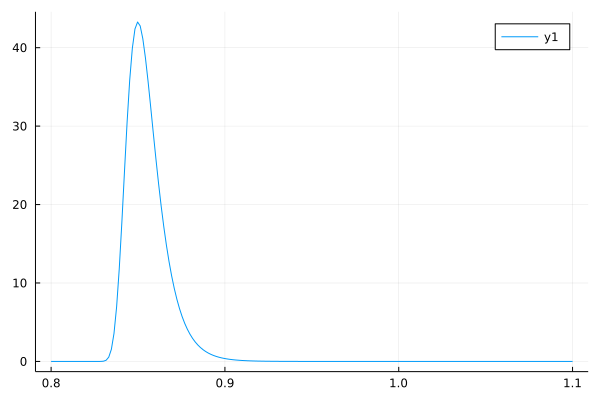

In [130]:
# dist


grid_w = range(0.8, 1.1, length = 200)
w = range(0.8, 1.1, length = 200)
dist = Frechet(θ,z)
F(w) = pdf(dist, w)
E = expectation(Frechet(θ,z),QuantileRange, n=200)
plot(w, F.(w))

In [131]:
# T
function T(V,U, grid_w, β, δ; compute_policy = false)


    Ve_func = LinearInterpolation(grid_w,V,extrapolation_bc=Line())

        U = b + β*E(x->max(Ve_func.(x),U))
        V = grid_w .+ β*((1-δ)*V .+ δ*U)
    
    
    # compute the reservation wage
    wbarindex = searchsortedfirst(V .- U, 0.0)
    if wbarindex >= length(w) # if this is true, you never want to accept
        w̄ = Inf
    else
        w̄ = w[wbarindex] # otherwise, return the number
    end
    
    
    return V,U,w̄;
end

T (generic function with 1 method)

In [132]:
cr = 1
Ve = grid_w

for i in 1:4000
    Ve, TVu = T(Ve,Vu, grid_w, β, δ; compute_policy = false)
    cr = abs(maximum(TVu-Vu))
    Vu = TVu
    if cr<1e-10
        break
    end
end

V, U, w̄ = T(Ve,Vu, grid_w, β, δ; compute_policy = true)
w̄

0.842211055276382

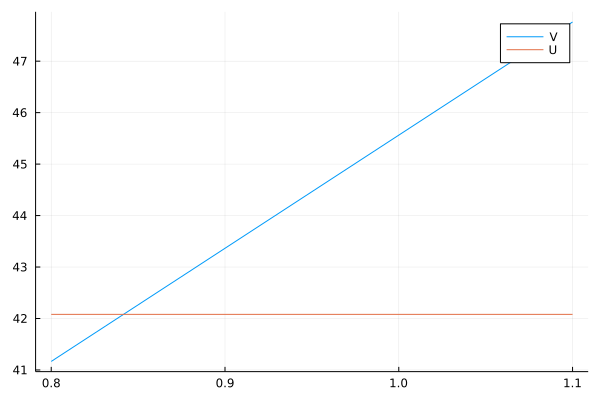

In [133]:
U_vec = fill(U, 200)
plot(w, [V U_vec], label = ["V" "U"])

In [134]:
function reservation_wage(β, δ)
    
    Vu = 1
    cr = 1
    Ve = grid_w

    for i in 1:4000
        Ve, TVu = T(Ve,Vu, grid_w, β, δ; compute_policy = false)
        cr = abs(maximum(TVu-Vu))
        Vu = TVu
        if cr<1e-10
            break
        end
    end

    V, U, w̄ = T(Ve,Vu, grid_w, β, δ; compute_policy = true)
    
    
    return w̄
end
    

reservation_wage (generic function with 2 methods)

In [135]:
grid_size = 25
R = rand(grid_size, grid_size)

δ_vals = range(0, 0.5, length = grid_size)
β_vals = range(0.9, 0.99, length = grid_size)

for (i, δ) in enumerate(δ_vals)
    for (j, β) in enumerate(β_vals)
        w̄ = reservation_wage(β, δ)
        R[i, j] = w̄
    end
end

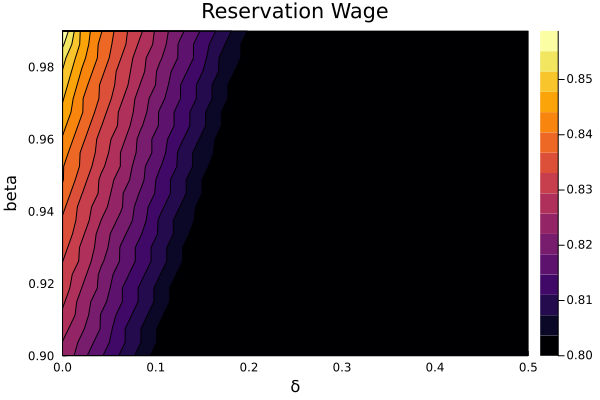

In [136]:
contour(δ_vals, β_vals, R',
        title = "Reservation Wage",
        xlabel = "δ",
        ylabel = "beta",
        fill = true)

In [137]:
grid_size = 25
R1 = rand(grid_size)

δ_vals = range(0, 0.5, length = grid_size)

for (i, δ) in enumerate(δ_vals)
        w̄1 = reservation_wage(0.98, δ)
        R1[i] = w̄1
        #R[i, j] = compute_reservation_wage(mcm(δ=δ, β=β)) 
end

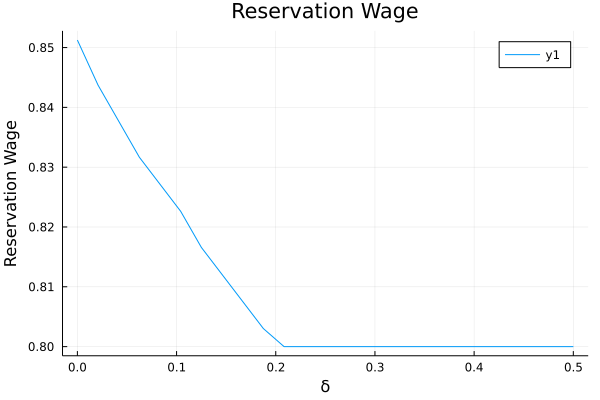

In [138]:
plot(δ_vals, R1,
        title = "Reservation Wage",
        xlabel = "δ",
        ylabel = "Reservation Wage")

In [139]:
# For planning in periods
# As we computed before
δ = 0.026
b = 0.55
Res = 0.842211055276382

dist1 = Frechet(θ,z)
w_offer = rand(dist1,1000,500)
w_work = zeros(1000,500)
state = zeros(1000,500)

for i in 1:500
   dest = rand(Bernoulli(δ),1000) # destruction
    if i>1
         for j in 1:1000
            if w_offer[j,i] > Res && state[j,i-1] == 0 
                w_work[j,i] = w_offer[j,i]
                state[j,i] = 1 
            elseif state[j,i-1] == 0 
                state[j,i] = 0
                w_work[j,i] = b
            end
        end

        for j in 1:1000
            if state[j,i-1] == 1 
                if dest[j] == 1
                    state[j,i] = 0
                    w_work[j,i] = b
                else
                    state[j,i] = 1
                    w_work[j,i] = w_work[j,i-1]
                end
            end
        end
    else
        for j in 1:1000
            if w_offer[j,i] > Res
               w_work[j,i] = w_offer[j,i] 
               state[j,i] = 1
            else
               w_work[j,i] = b 
            end
        end
    end
end

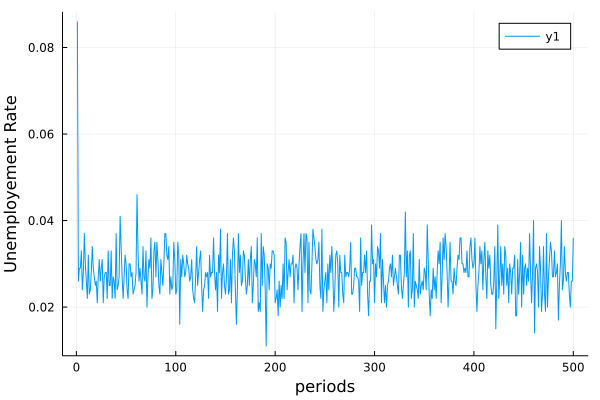

In [140]:
iter = 1:500
plot(iter, (sum(ones(1000,500)- state, dims=1)/1000)',xlabel="periods",ylabel="Unemployement Rate")

In [141]:
#calibration

avgunemployed = 0.07
δ = 0.026 
b = 0.55
Res = 0.842211055276382



grid_size = 100
D1 = rand(grid_size)
x = 1

δ_vals = range(0, 0.2, length = grid_size)

for (i, δ) in enumerate(δ_vals)
        w̄2 = reservation_wage(0.98, δ)
        Res = w̄2

        w_offer = rand(Frechet(θ,z),1000,500)
        w_work = zeros(1000,500)
        state = zeros(1000,500)
        new_offer = zeros(1000,500)

        for i in 1:500
           dest = rand(Bernoulli(δ),1000) # destruction
            if i>1
                 for j in 1:1000
                    if w_offer[j,i] > Res && state[j,i-1] == 0 
                        w_work[j,i] = w_offer[j,i]
                        state[j,i] = 1 
                    elseif state[j,i-1] == 0 
                        state[j,i] = 0
                        w_work[j,i] = b
                    end
                end

                for j in 1:1000
                    if state[j,i-1] == 1 
                        if dest[j] == 1
                            state[j,i] = 0
                            w_work[j,i] = b
                        else
                            state[j,i] = 1
                            w_work[j,i] = w_work[j,i-1]
                        end
                    end
                end
            else
                for j in 1:1000
                    if w_offer[j,i] > Res
                       w_work[j,i] = w_offer[j,i] 
                       state[j,i] = 1
                    else
                       w_work[j,i] = b 
                    end
                end
            end
        end

       un = (sum(ones(1000,500) - state, dims=1)/1000)'
       x = un[500]    
        
    
        
        D1[i] = x - avgunemployed
end

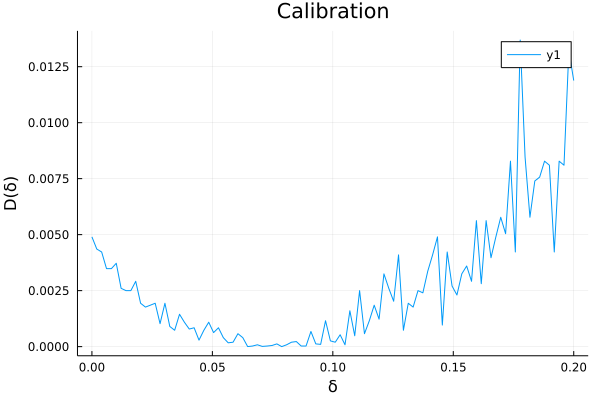

In [128]:
D = zeros(100)

for i in 1:100
    D[i] = (D1[i])^2
end

plot(δ_vals, D,
        title = "Calibration",
        xlabel = "δ",
        ylabel = "D(δ)")

In [149]:
@show δ_vals[argmin(D)]

δ_vals[argmin(D)] = 0.07878787878787878


0.07878787878787878